In [0]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
import torch.optim as optim

from torch.autograd import Variable

import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import random

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
!pip install torchsummary

In [0]:
from torchsummary import summary

In [0]:
class Generator(nn.Module):

    def __init__(self, f=32):
        super(Generator, self).__init__()

        # base depth nb of feature maps
        self.f = f

        def dc_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_size, out_size, k, s, p, bias=False),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True))

        self.main = nn.Sequential(
            dc_block(100, self.f * 8, 2, 1, 0),
            dc_block(self.f * 8, self.f * 4),
            dc_block(self.f * 4, self.f * 2),
            dc_block(self.f * 2, self.f),
            nn.ConvTranspose2d(self.f, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [0]:
def dcgan_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Norm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Encoder(nn.Module):

    def __init__(self, f=32):
        super(Encoder, self).__init__()

        # base depth nb of feature maps
        self.f = f

        def dc_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.Conv2d(in_size, out_size, k, s, p, bias=False),
                nn.BatchNorm2d(out_size),
                nn.LeakyReLU(0.2, inplace=True))

        self.main = nn.Sequential(
            nn.Conv2d(3, self.f, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            dc_block(self.f, self.f * 2),
            dc_block(self.f * 2, self.f * 4),
            dc_block(self.f * 4, self.f * 8),
        )

        self.x_size = self.f * 8 * 2 * 2
        self.mean =  nn.Linear(self.x_size, 100)
        self.logvar =  nn.Linear(self.x_size, 100)
        
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.main(x)
        x = x.view([-1, self.x_size])
        mean = self.mean(x)
        logvar = self.logvar(x)
        
        return mean, logvar

In [0]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Generator()
        
        self.encoder.apply(dcgan_init)
        self.decoder.apply(dcgan_init)
        
        self.criterion = nn.MSELoss(reduction='sum')
        self.batch_size = 0
        
    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5*logvar) 
        eta = torch.randn_like(mean)  
        return eta.mul(std).add_(mean)
        
    def forward(self, x):
        self.batch_size = x.size()[0]
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        z_size = z.size()
        z = z.view(z_size[0], z_size[1], 1, 1)
        reconstrunction_pixel_means = self.decoder(z)
        return reconstrunction_pixel_means, mean, logvar
      
    #def generate_image(self, reconstrunction_pixel_means):
        #image_size = reconstrunction_pixel_means.size()
        #reconstructed_image = torch.empty(*image_size, dtype=reconstrunction_pixel_means.dtype, device=reconstrunction_pixel_means.device)
        #image_total_num = image_size[1]*image_size[2]*image_size[3]
        #I_std = torch.eye(image_total_num)
        #for i in range(self.batch_size):
        #  flattend_mean = reconstrunction_pixel_means[i].view(-1,image_total_num)
        #  dist = torch.distributions.multivariate_normal.MultivariateNormal(flattend_mean, I_std)
        #  reconstructed_image[i] = dist.sample((1,)).view(1,image_size[1],image_size[2],image_size[3])
        #return reconstructed_image
      
    def loss(self, reconstrunction_pixel_means, x, mean, logvar):
        recon_loss = self.criterion(reconstrunction_pixel_means, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
        return recon_loss , kl_loss

In [0]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader


In [0]:
batch_size = 32
train, valid, test = get_data_loader("svhn", batch_size)

  0%|          | 0/182040794 [00:00<?, ?it/s]

182042624it [00:06, 29320148.23it/s]                               
  0%|          | 0/64275384 [00:00<?, ?it/s]

64282624it [00:03, 19426923.24it/s]                              


In [0]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

In [0]:
model = VAE()
model.to(device)
summary(model, (3, 32, 32))
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
epochs = 30
kl_weight = 2

input_img_list = []
img_list = []

epoch_train_loss = []
epoch_train_kl_loss = []
epoch_valid_loss = []
epoch_valid_kl_loss = []

data_len_train = len(train.dataset)*batch_size
data_len_valid = len(valid.dataset)*batch_size

for epoch in range(epochs):
  print('epoch = ',epoch)
  total_loss = 0
  kl_loss_total = 0
  model.train()
  for x, y in train:
    x = x.to(device)
    optimizer.zero_grad()
    reconstrunction_pixel_means, mean, logvar = model.forward(x)
    recon_loss,kl_loss = model.loss(reconstrunction_pixel_means, x, mean, logvar)
    if epoch < 5:
      loss = recon_loss
    else:
      loss = recon_loss + kl_weight*kl_loss
    total_loss += loss.item()
    kl_loss_total += kl_loss.item()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    kl_loss_total += kl_loss.item()
  epoch_train_loss.append(total_loss/data_len_train)
  epoch_train_kl_loss.append(kl_loss_total/data_len_train)

  total_loss = 0
  kl_loss_total = 0
  model.eval()
  for x, y in valid:
    x = x.to(device)
    reconstrunction_pixel_means, mean, logvar = model.forward(x)
    loss, kl_loss = model.loss(reconstrunction_pixel_means, x, mean, logvar)
    total_loss += loss.item()
    kl_loss_total += kl_loss.item()
    
  total_loss = total_loss/data_len_valid
  kl_loss_total = kl_loss_total/data_len_valid
  print(total_loss,kl_loss_total)
  epoch_valid_loss.append(total_loss)
  epoch_valid_kl_loss.append(kl_loss_total)

  
  with torch.no_grad():        
    input_img_list.append(vutils.make_grid(x, padding=2, normalize=True))
    img_list.append(vutils.make_grid(reconstrunction_pixel_means, padding=2, normalize=True))

  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,536
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,768
       BatchNorm2d-4             [-1, 64, 8, 8]             128
         LeakyReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 4, 4]         131,072
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 256, 2, 2]         524,288
      BatchNorm2d-10            [-1, 256, 2, 2]             512
        LeakyReLU-11            [-1, 256, 2, 2]               0
           Linear-12                  [-1, 100]         102,500
           Linear-13                  [-1, 100]         102,500
          Encoder-14     [[-1, 100], [-

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


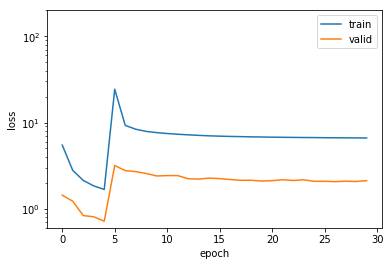

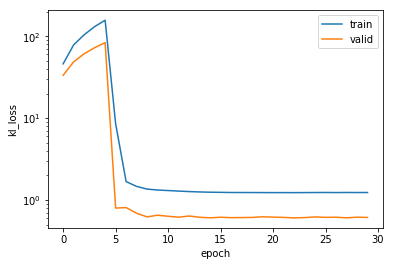

In [0]:
plt.semilogy(epoch_train_loss, label ="train")
plt.semilogy(epoch_valid_loss, label ="valid")
plt.ylim([-10,200])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.semilogy(epoch_train_kl_loss, label ="train")
plt.semilogy(epoch_valid_kl_loss, label ="valid")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('kl_loss')
plt.show()
    

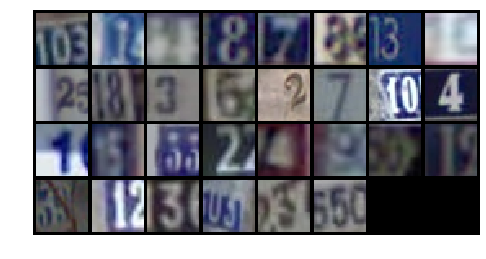

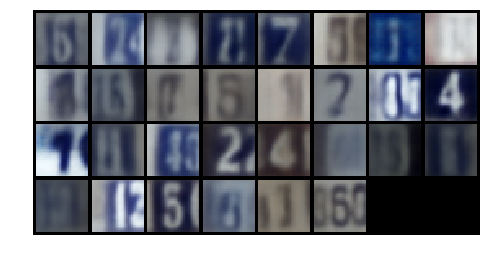

In [0]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in input_img_list]
ani1 = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani2 = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani1.to_jshtml())
HTML(ani2.to_jshtml())

In [0]:
!rm -rf /content/vae_samples/
!mkdir /content/vae_samples/
!mkdir /content/vae_samples/samples

!rm -rf /content/vae_true_samples/
!mkdir /content/vae_true_samples/
!mkdir /content/vae_true_samples/samples


In [0]:
count = 0
with torch.no_grad():
  I_std = torch.eye(100)
  zero_means = torch.zeros(100)
  z = torch.distributions.multivariate_normal.MultivariateNormal(zero_means, I_std).sample((1000,))
  z_size = z.size()
  z = z.view(z_size[0], z_size[1], 1, 1)
  z = z.to(device)
  reconstrunction_pixel_means = model.decoder(z)
  images = reconstrunction_pixel_means.cpu().numpy()
  for k,j in enumerate(images):
    plt.imsave("/content/vae_samples/samples/vae_"+str(count)+".jpg",np.transpose(j,(1,2,0)))
    count += 1


In [0]:
  #count = 0
  #with torch.no_grad():
  #  for x, y in test:
  #    x = x.to(device)
  #    reconstrunction_pixel_means, mean, logvar = model.forward(x)
  #    images = reconstrunction_pixel_means.cpu().numpy()
  #    true_images = x.cpu().numpy()
  #    for k,j in enumerate(images):
  #      if count < 10:
  #        plt.imsave("/content/vae_true_samples/samples/vae_"+str(count)+"_label_"+str(y[k].item())+"_true.jpg",np.transpose(true_images[k],(1,2,0)))
  #        #plt.imsave("/content/vae_samples/samples/vae_"+str(count)+"_label_"+str(y[k].item())+".jpg",np.transpose(j,(1,2,0)))
  #        count += 1
    
    

In [0]:
!rm -rf vae_samples.zip 
!rm -rf vae_true_samples.zip

!zip -r vae_samples.zip /content/vae_samples
!zip -r vae_true_samples.zip /content/vae_true_samples



  adding: content/vae_samples/ (stored 0%)
  adding: content/vae_samples/samples/ (stored 0%)
  adding: content/vae_samples/samples/vae_14.jpg (deflated 11%)
  adding: content/vae_samples/samples/vae_222.jpg (deflated 10%)
  adding: content/vae_samples/samples/vae_339.jpg (deflated 10%)
  adding: content/vae_samples/samples/vae_196.jpg (deflated 11%)
  adding: content/vae_samples/samples/vae_175.jpg (deflated 11%)
  adding: content/vae_samples/samples/vae_915.jpg (deflated 9%)
  adding: content/vae_samples/samples/vae_886.jpg (deflated 12%)
  adding: content/vae_samples/samples/vae_492.jpg (deflated 17%)
  adding: content/vae_samples/samples/vae_591.jpg (deflated 10%)
  adding: content/vae_samples/samples/vae_483.jpg (deflated 10%)
  adding: content/vae_samples/samples/vae_74.jpg (deflated 18%)
  adding: content/vae_samples/samples/vae_278.jpg (deflated 10%)
  adding: content/vae_samples/samples/vae_360.jpg (deflated 19%)
  adding: content/vae_samples/samples/vae_204.jpg (deflated 10%)

In [0]:
vae_filename = '/content/vae_2'

torch.save(model.state_dict(), vae_filename)